# VIX Modeling

In this notebook, we evaluate three different models of the VIX that we may use in our trading algorithm.

First, we import the libraries we need for our models. Some are more common (yfinance, pandas, numpy, matplotlib), while others are less so.

We import arch.arch_model, where arch is a library that allows us to model the VIX using a GARCH(1, 1) model (see [here](https://bashtage.github.io/arch/univariate/univariate_volatility_modeling.html) and [here](https://bashtage.github.io/arch/univariate/introduction.html) for documentation).

We also import the ARIMA model from the [statsmodels library](https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima.model.ARIMA.html), as well as other functions from [tensorflow](https://keras.io/about/).

In [1]:
# Import libraries
import datetime as dt
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU

Next, we download the necessary VIX data using YahooFinance. We will split the data into training and testing data for each of our models, beginning testing on January 1, 2022.

Quick note: setting progress to `False` hides the progress bar while the data is downloading

In [2]:
# Download VIX data
start_training = dt.date(2005, 1, 1)
end_training = dt.date(2021, 12, 31)
start_test = dt.date(2022, 1, 1)
end_test = dt.datetime.today()

# Split the data into training and testing
vix_train = yf.download('^VIX', start=start_training, end=end_training, progress=False)
vix_test = yf.download('^VIX', start=start_test, end=end_test, progress=False)

Next, we will convert our dataset from daily to weekly intervals. This decreases the daily noise of our data, and also makes it much easier to work with the ARIMA model frequency attribute.

In [3]:
# Converting our data from daily to weekly
# Open - assigned to first price of the week
# High - weekly maximum
# Low - weekly minimum
# Close - assigned to last price of the week
# Adj Close - adjusted close of the week (factors in dividends, splits, etc.)

vix_train = vix_train.resample('W').agg({'Open':'first', 'High':'max', 'Low':'min',
    'Close':'last', 'Adj Close': 'last'})

We then calculate the log returns of the VIX for our modeling, shifting by 1 to offset the first day of the dataset. The second line drops this part of the table, as it has a NaN value.

In [4]:
# Calculate log returns
vix_train['log_returns'] = np.log(vix_train['Adj Close'] / vix_train['Adj Close'].shift(1))
vix_train.dropna(inplace=True)

### GARCH model
Using the arch_model from our arch library, we model the log returns of the VIX, setting error and time dependency terms to order of magnitude of 1. This creates the GARCH(1, 1) model that is widely used in modeling, notable for its simplicity and ease of implementation. We then use the arch_garch_model.fit() method to fit our model. This produces an output table that is printed at the end.

In [5]:
# GARCH model
garch_model = arch_model(vix_train['log_returns'], vol='Garch', p=1, q=1, rescale=False)
garch_fit = garch_model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 17510.04655653343
Iteration:      2,   Func. Count:     16,   Neg. LLF: 2725.1338595381317
Iteration:      3,   Func. Count:     24,   Neg. LLF: -414.0096901346743
Iteration:      4,   Func. Count:     31,   Neg. LLF: -403.50666538532244
Iteration:      5,   Func. Count:     37,   Neg. LLF: -437.2105286503494
Iteration:      6,   Func. Count:     43,   Neg. LLF: -437.3042153075197
Iteration:      7,   Func. Count:     48,   Neg. LLF: -437.3058858692902
Iteration:      8,   Func. Count:     53,   Neg. LLF: -437.3058873544155
Iteration:      9,   Func. Count:     57,   Neg. LLF: -437.3058873543909
Optimization terminated successfully    (Exit mode 0)
            Current function value: -437.3058873544155
            Iterations: 9
            Function evaluations: 57
            Gradient evaluations: 9


### ARIMA model
Next, we use the ARIMA library to model the VIX returns, where we set the lag value to 1 for autoregression, have no time differencing, and set our moving averave component order to 1. This means that our model will use the previous value and error term to predict future values of the time series (the VIX).

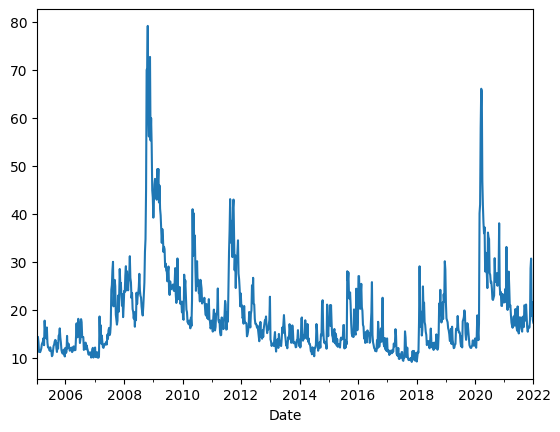

In [6]:
vix_train['Adj Close'].plot()
adjclose = vix_train['Adj Close']

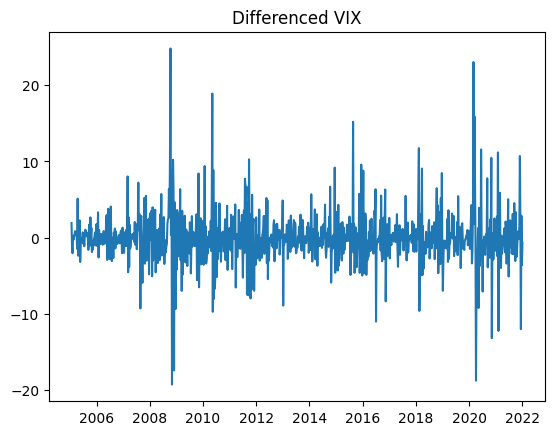

In [7]:
diff = adjclose.diff().dropna()
plt.plot(diff)
plt.title('Differenced VIX')
plt.show()

In [8]:
print(diff)

Date
2005-01-23     1.929999
2005-01-30    -1.120000
2005-02-06    -2.030000
2005-02-13     0.220000
2005-02-20    -0.250000
                ...    
2021-12-05     2.049999
2021-12-12   -11.980000
2021-12-19     2.879999
2021-12-26    -3.610001
2022-01-02    -0.629999
Freq: W-SUN, Name: Adj Close, Length: 885, dtype: float64


Date
2005-01-23     1.929999
2005-01-30    -1.120000
2005-02-06    -2.030000
2005-02-13     0.220000
2005-02-20    -0.250000
                ...    
2021-12-05     2.049999
2021-12-12   -11.980000
2021-12-19     2.879999
2021-12-26    -3.610001
2022-01-02    -0.629999
Freq: W-SUN, Name: Adj Close, Length: 885, dtype: float64


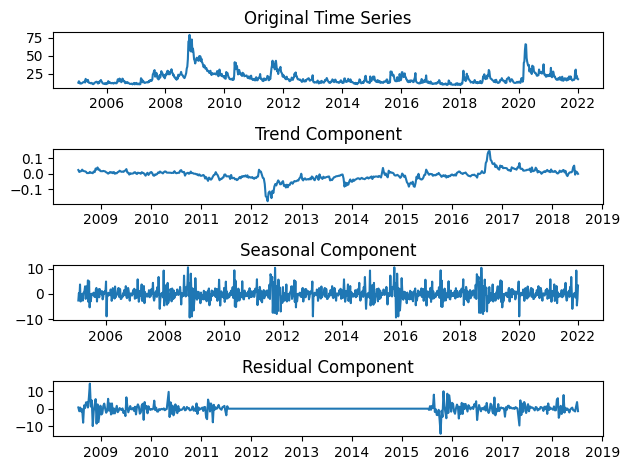

In [9]:
diff.sort_index(inplace=True)
#diff['date'] = pd.to_datetime(diff['date'])
print(diff)
# Decompose time series
decomposition = seasonal_decompose(diff, model='additive', period = 365)

# Plot original time series
plt.subplot(411)
plt.plot(adjclose)
plt.title('Original Time Series')

# Plot trend component
plt.subplot(412)
plt.plot(decomposition.trend)
plt.title('Trend Component')

# Plot seasonal component
plt.subplot(413)
plt.plot(decomposition.seasonal)
plt.title('Seasonal Component')

# Plot residual component
plt.subplot(414)
plt.plot(decomposition.resid)
plt.title('Residual Component')

# Show plots
plt.tight_layout()
plt.show()

C:\Users\pjbro\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\pjbro\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\pjbro\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\pjbro\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as st

{(0, 0, 0): 4745.349859097289, (0, 0, 1): 4730.795698852894, (0, 0, 2): 4732.790030281672, (0, 0, 3): 4730.4200433396145, (0, 1, 0): 5464.695771690191, (0, 1, 1): 4747.791329915261, (0, 1, 2): 4733.537662689287, (0, 1, 3): 4735.522213294127, (0, 2, 0): 6469.109714355758, (0, 2, 1): 5468.300518279737, (0, 2, 2): 4761.2471640270605, (0, 2, 3): 4747.901688084381, (1, 0, 0): 4730.718434047831, (1, 0, 1): 4732.60932320708, (1, 0, 2): 4731.585319734615, (1, 0, 3): 4712.185423972462, (1, 1, 0): 5120.9168284763, (1, 1, 1): 4733.420544769852, (1, 1, 2): 4735.188629921484, (1, 1, 3): 4734.277972164704, (1, 2, 0): 5837.799131319078, (1, 2, 1): 5125.812024136119, (1, 2, 2): 4747.552178938585, (1, 2, 3): 4764.2730224763545, (2, 0, 0): 4732.715112312254, (2, 0, 1): 4711.575749797588, (2, 0, 2): 4709.187816226076, (2, 0, 3): 4711.081123341464, (2, 1, 0): 5027.554183879234, (2, 1, 1): 4735.411143945887, (2, 1, 2): 4734.726755337355, (2, 1, 3): 4738.151424166521, (2, 2, 0): 5599.1655936136, (2, 2, 1): 

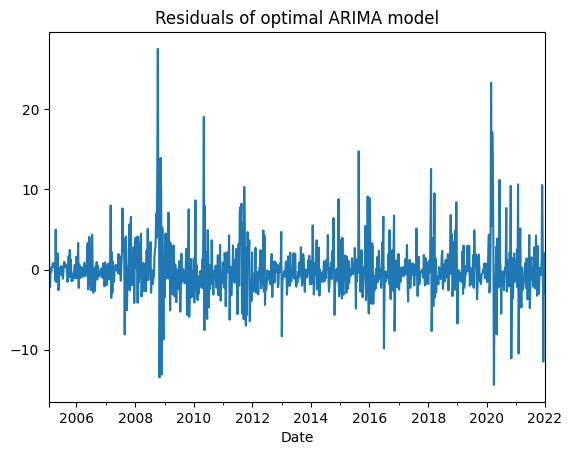

In [31]:
# ARIMA model
from itertools import product

p = range(0, 4)
d = range(0, 3)
q = range(0, 4)
pdq = list(product(p, d, q))

# Fit and evaluate each ARIMA model using AIC
models = {}
for para in pdq:
#     print(para)
    try:
        model = ARIMA(diff, order=para)
        results = model.fit()
        models[para] = results.aic
    except:
        continue

print(models)

# Select the best ARIMA model based on the lowest AIC value
best_para, best_aic = min(models.items(), key=lambda x: x[1])
best_model = ARIMA(diff, order=best_para)
results = best_model.fit()

# Print the summary of the best ARIMA model
print(results.summary())

# Plot the residuals of the best ARIMA model
residuals = pd.DataFrame(results.resid)
residuals.plot(label='Residuals')
plt.title('Residuals of optimal ARIMA model')
plt.legend().remove()
plt.show()

### GRU RNN Model

Finally, we prepare our data and train a Gated Recurrent Unit (GRU) based Recurrent Neural Network (RNN) model for time series prediction on our VIX log returns. The model is designed with a single-layer GRU containing 4 units, and takes into account the previous value of the time series for making predictions.

For our neural net, we define a GRU RNN model with 4 unit, and compile using mean squared error as the loss function and the Adam optimizer. We then use 70 epochs for our training and a batch size of 1, though this can be adjusted depending on available compute.

This GRU RNN model serves as a neural network-based approach to predict future values of the VIX log returns, leveraging the temporal relationships within the time series data.

In [ ]:
# Data preparation for GRU RNN model
train_data = vix_train['log_returns'].values.reshape(-1, 1)

# Scaling the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = scaler.fit_transform(train_data)

# Prepare data for time series model
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        x = dataset[i:(i + look_back), 0]
        y = dataset[i + look_back, 0]
        X.append(x)
        Y.append(y)
    return np.array(X), np.array(Y)

look_back = 1
X_train, y_train = create_dataset(train_data_scaled, look_back)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

# GRU RNN model
# Lowered the number of epochs so my computer didn't die
gru_rnn_model = Sequential()
gru_rnn_model.add(GRU(4, input_shape=(1, look_back)))
gru_rnn_model.add(Dense(1))
gru_rnn_model.compile(loss='mean_squared_error', optimizer='adam')
# epochs = 70 so that my laptop doesn't end itself
gru_rnn_model.fit(X_train, y_train, epochs=70, batch_size=1, verbose=0)

### Print Model Summaries
We them print a summary of each of our models, which gives us an indication of their parameters, as well as how well they perform.

In [77]:
# Model summaries
print("ARCH/GARCH Model Summary:")
print(arch_garch_fit.summary())
print("\nARIMA Model Summary:")
print(arima_fit.summary())
print("\nGRU RNN Model Summary:")
gru_rnn_model.summary()

ARCH/GARCH Model Summary:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:            log_returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                6217.28
Distribution:                  Normal   AIC:                          -12426.6
Method:            Maximum Likelihood   BIC:                          -12400.8
                                        No. Observations:                 4671
Date:                Mon, Mar 27 2023   Df Residuals:                     4670
Time:                        20:13:37   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -5.3417e-04  8.

### Example output from first run